## Conte Core release MRI availability figure

- Extract number of repeats of structural and functional series by subject and session (protocol version)
- Create availability matrices for sMRI and fMRI series and composite into a single, large figure

AUTHOR : Mike Tyszka  
PLACE  : Caltech Brain Imaging Center  
DATES  : 2021-08-04 JMT From scratch  

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load pickled MRI availability dataframe
avail_df = pd.read_pickle('MRI_availability_dataframe.pkl')

n_unique = len(avail_df['subject'].unique())
print(f'Loaded MRI availability data for {n_unique} unique subjects')

Loaded MRI availability data for 117 unique subjects


## Structural MRI Availability

In [3]:
# Select anatomic images with criteria
smri_df = avail_df[avail_df['datatype']=='anat'].copy()

# Retain only bias corrected images ('NORM' in ImageType)
smri_df = smri_df[smri_df['ImageType'].str.contains('NORM')]

# Retain only MEMPRAGE combined images
is_memprage = smri_df['SequenceName'].str.contains('tfl3d4_16ns')
is_combined = smri_df['ImageType'].str.contains('COMBINED')
smri_df = smri_df[~(is_memprage & ~is_combined)]

### T1 and T2 Counts by Session

In [4]:
# Count number of T1s and T2s for each session type
smri_by_sess_df = smri_df[['subject', 'session', 'suffix']].groupby(['session', 'suffix']).count()

# Put subjects in columns, (session, suffix) as row multiindex
smri_by_sess_df = smri_by_sess_df.unstack(level=0, fill_value=0)

# Drop the empty datatype level in the column multiindex
smri_by_sess_df.columns = smri_by_sess_df.columns.droplevel()

smri_by_sess_df

session,core1p1,core1p2,core1p3p0,core1p3p1,core2p2
suffix,,,,,
T1w,68,90,18,14,59
T2w,0,0,9,6,58


### T1 and T2 Counts by Subject and Session

In [5]:
# Count number of T1s and T2s for each subject/session
# Use datatype as dummy column to generate counts
smri_by_subjsess_df = smri_df[['subject', 'session', 'suffix', 'datatype']].groupby(['subject', 'suffix', 'session']).count()

# Put subjects in columns, (session, suffix) as multiindex
smri_by_subjsess_df = smri_by_subjsess_df.unstack(level=0, fill_value=0)

# Drop the empty datatype level in the column multiindex
smri_by_subjsess_df.columns = smri_by_subjsess_df.columns.droplevel()

## Functional MRI Availability

In [6]:
# Select fMRI with criteria
fmri_df = avail_df[avail_df['datatype']=='func'].copy()

# Count only BOLD EPI for rest, pixar and bang
is_bold = fmri_df['suffix'].str.contains('bold')
is_rest = fmri_df['task'].str.contains('rest')
is_pixar = fmri_df['task'].str.contains('pixar')
is_bang = fmri_df['task'].str.contains('bang')
fmri_df = fmri_df[is_bold & (is_rest | is_pixar | is_bang)]

### Task Counts by Session

In [7]:
# Count number of BOLD series for each session (protocol version)
task_by_sess_df = fmri_df[['subject', 'session', 'suffix']].groupby(['session', 'suffix']).count()

# Put subjects in columns, (session, suffix) as row multiindex
task_by_sess_df = task_by_sess_df.unstack(level=0, fill_value=0)

# Drop the empty datatype level in the column multiindex
task_by_sess_df.columns = task_by_sess_df.columns.droplevel()

task_by_sess_df

session,core1p1,core1p2,core1p3p0,core1p3p1,core2p2
suffix,,,,,
bold,68,89,18,14,231


### Task Counts by Subject and Session

In [8]:
# Count number of each task for each subject/session
# Use datatype as dummy column to generate counts later
task_by_subjsess_df = fmri_df[['subject', 'session', 'task', 'datatype']].groupby(['subject', 'task', 'session']).count()

# Put subjects in columns, (task, session) as row multiindex
task_by_subjsess_df = task_by_subjsess_df.unstack(level=0, fill_value=0)

# Drop the empty datatype level in the column multiindex
task_by_subjsess_df.columns = task_by_subjsess_df.columns.droplevel()

## Availability Matrix Figures

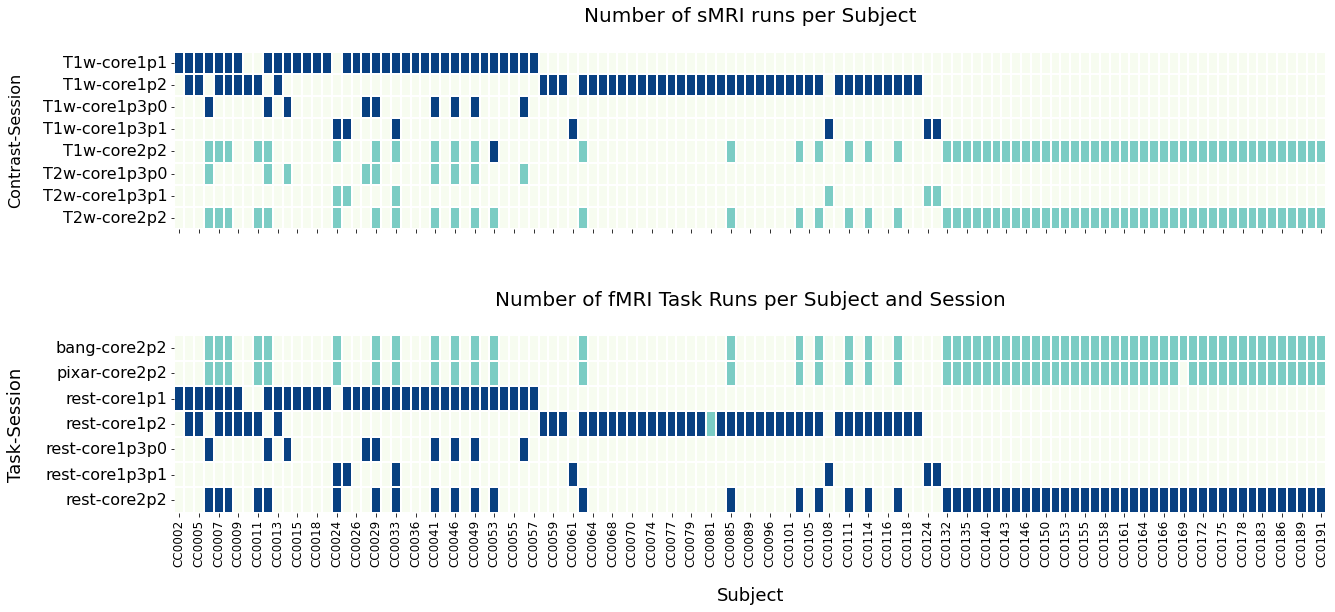

In [9]:
# Create release MRI availability matrix subplots

fig, axs = plt.subplots(2, 1, figsize=(20, 8), sharex=True)

#
# Structural series per subject
#

hmap = sns.heatmap(
    smri_by_subjsess_df,
    ax=axs[0],
    vmin=0, vmax=3,
    linewidths=2,
    cmap=plt.get_cmap('GnBu', 3),
    cbar=False
)

hmap.set_title('Number of sMRI runs per Subject', fontsize=20, pad=30)
hmap.set_xlabel('')
hmap.set_ylabel('Contrast-Session', fontsize=16, labelpad=20)
hmap.xaxis.set_ticks([])
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize = 16)

#
# fMRI task runs per subject and session
#

hmap = sns.heatmap(
    task_by_subjsess_df,
    ax=axs[1],
    vmin=0, vmax=3,
    linewidths=2,
    cmap=plt.get_cmap('GnBu', 3),
    cbar=False
)

hmap.set_title('Number of fMRI Task Runs per Subject and Session', fontsize=20, pad=30)
hmap.set_xlabel('Subject', fontsize=18, labelpad=20)
hmap.set_ylabel('Task-Session', fontsize=18, labelpad=20)
hmap.set_xticklabels(hmap.get_xmajorticklabels(), fontsize = 12)
hmap.set_yticklabels(hmap.get_ymajorticklabels(), fontsize = 16)

# Increase vertical spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.6)

# Save complete figure to PNG
plt.savefig('MRI_availability_figure.png', dpi=300, bbox_inches = 'tight')